## General Information

This notebook is used to train a simple neural network model to predict the chemistry in the barite benchmark (50x50 grid). The training data is stored in the repository using **git large file storage** and can be downloaded after the installation of git lfs using the `git lfs pull` command.

It is then recommended to create a Python environment using miniconda. The necessary dependencies are contained in `environment.yml` and can be installed using `conda env create -f environment.yml`.

The data set is divided into a design and result part and consists of the iterations of a reference simulation. The design part of the data set contains the chemical concentrations at time $t$ and the result part at time $t+1$, which are to be learned by the model.

## Setup Libraries

In [197]:
import keras
import tensorflow as tf
import h5py
import numpy as np
import pandas as pd
import time
import sklearn.model_selection as sk
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import os
from preprocessing import *
from sklearn import set_config
from importlib import reload
set_config(transform_output = "pandas")

In [136]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define parameters

In [ ]:
dtype = "float32"
activation = "relu"

lr = 0.001
batch_size = 512
epochs = 50 # default 400 epochs

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=lr,
    decay_steps=2000,
    decay_rate=0.9,
    staircase=True
)

optimizer_simple = keras.optimizers.Adam(learning_rate=lr_schedule)
optimizer_large = keras.optimizers.Adam(learning_rate=lr_schedule)
optimizer_paper = keras.optimizers.Adam(learning_rate=lr_schedule)


loss = keras.losses.Huber()

sample_fraction = 0.8

## Setup the model

In [150]:
# small model
model_simple = keras.Sequential(
    [
        keras.Input(shape = (9,), dtype = "float32"),
        keras.layers.Dense(units = 128, activation = "relu", dtype = "float32"),
        keras.layers.Dense(units = 128, activation = "relu", dtype = "float32"),
        keras.layers.Dense(units = 9, dtype = "float32")
    ]
)

model_simple.compile(optimizer=optimizer_simple, loss = loss)
model_simple.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 128)            │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,953 (74.04 KB)

 Trainable params: 18,953 (74.04 KB)

 Non-trainable params: 0 (0.00 B)

In [161]:
# large model
model_large =   keras.Sequential(
    [keras.layers.Input(shape=(9,), dtype=dtype),
     keras.layers.Dense(512, activation='relu', dtype=dtype),
     keras.layers.Dense(1024, activation='relu', dtype=dtype),
     keras.layers.Dense(512, activation='relu', dtype=dtype),
     keras.layers.Dense(9, dtype=dtype)
     ])

model_large.compile(optimizer=optimizer_large, loss = loss)
model_large.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 512)            │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,059,849 (4.04 MB)

 Trainable params: 1,059,849 (4.04 MB)

 Non-trainable params: 0 (0.00 B)

In [140]:
# model from paper
# (see https://doi.org/10.1007/s11242-022-01779-3 model for the complex chemistry)
model_paper =   keras.Sequential(
    [keras.layers.Input(shape=(12,), dtype=dtype),
     keras.layers.Dense(128, activation='relu', dtype=dtype),
     keras.layers.Dense(256, activation='relu', dtype=dtype),
     keras.layers.Dense(512, activation='relu', dtype=dtype),
     keras.layers.Dense(256, activation='relu', dtype=dtype),
     keras.layers.Dense(12, dtype=dtype)
     ])

model_paper.compile(optimizer=optimizer_paper, loss = loss)
model_paper.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 300,684 (1.15 MB)

 Trainable params: 300,684 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

## Define transformer functions

In [141]:
def Safelog(val):
    # get range of vector
    if val > 0:
        return np.log10(val)
    elif val < 0:
        return -np.log10(-val)
    else:
        return 0

def Safeexp(val):
    if val > 0:
        return -10 ** -val
    elif val < 0:
        return 10 ** val
    else:
        return 0

In [142]:
# ? Why does the charge is using another logarithm than the other species

func_dict_in = {
    "H" : np.log1p,
    "O" : np.log1p,
    "Charge" : Safelog,
    "H_0_" : np.log1p,
    "O_0_" : np.log1p,
    "Ba" : np.log1p,
    "Cl" : np.log1p,
    "S_2_" : np.log1p,
    "S_6_" : np.log1p,
    "Sr" : np.log1p,
    "Barite" : np.log1p,
    "Celestite" : np.log1p,
}

func_dict_out = {
    "H" : np.expm1,
    "O" : np.expm1,
    "Charge" : Safeexp,
    "H_0_" : np.expm1,
    "O_0_" : np.expm1,
    "Ba" : np.expm1,
    "Cl" : np.expm1,
    "S_2_" : np.expm1,
    "S_6_" : np.expm1,
    "Sr" : np.expm1,
    "Barite" : np.expm1,
    "Celestite" : np.expm1,
}


## Read data from `.h5` file and convert it to a `pandas.DataFrame`

In [143]:
# os.chdir('/mnt/beegfs/home/signer/projects/model-training')
data_file = h5py.File("Barite_50_Data_training.h5")

design = data_file["design"]
results = data_file["result"]

df_design = pd.DataFrame(np.array(design["data"]).transpose(), columns = np.array(design["names"].asstr()))
df_results = pd.DataFrame(np.array(results["data"]).transpose(), columns = np.array(results["names"].asstr()))

data_file.close()

## Preprocess Data

The data are preprocessed in the following way:

1. Label data points in the `design`  dataset with `reactive` and `non-reactive` labels using kmeans clustering
2. Transform `design` and `results` data set into log-scaled data.
3. Split data into training and test sets.
4. Learn scaler on training data for `design` and `results` together (option `global`) or individual (option `individual`).
5. Transform training and test data.
6. Split training data into training and validation dataset.

In [182]:
species_columns = ["H", "O", "Charge", "Ba", "Cl", "S_6_", "Sr", "Barite", "Celestite"]

In [183]:
X_train, X_val, X_test, y_train, y_val, y_test, scaler_X, scaler_y = preprocessing_training(df_design[species_columns], df_results[species_columns], func_dict_in, func_dict_out, "off", 'global', 0.1)

/home/signer/bin/miniconda3/envs/training/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Amount class 0 before: 0.9879169719169719
Amount class 1 before: 0.012083028083028084


## Custom Loss function

In [146]:
def custom_loss_H20(df_design_log, df_result_log, data_min_log, data_max_log, func_dict_out, postprocess):
    df_result = postprocess(df_result_log, func_dict_out, data_min_log, data_max_log)    
    return keras.losses.Huber + np.sum(((df_result['H'] / df_result['O']) - 2)**2)

def loss_wrapper(data_min_log, data_max_log, func_dict_out, postprocess):
    def loss(df_design_log, df_result_log):
        return custom_loss_H20(df_design_log, df_result_log, data_min_log, data_max_log, func_dict_out, postprocess)
    return loss

In [199]:
def custom_loss(scaler_X, scaler_y, FuncTransform, dict_in, dict_out, columns):
    def loss(results, predicted):
        
        predicted = pd.DataFrame(scaler_X.inverse_transform(predicted), columns = columns)
        results = pd.DataFrame(scaler_y.inverse_transform(results), columns = columns)
        
        predicted = FuncTransform(dict_in, dict_out).inverse_transform(predicted)
        results = FuncTransform(dict_in, dict_out).inverse_transform(results)
        
        dBa = tf.keras.backend.abs((predicted["Ba"] + predicted["Barite"]) - (results["Ba"] + results["Barite"]))
        dSr = tf.keras.backend.abs((predicted["Sr"] + predicted["Celestite"]) - (results["Sr"] + results["Celestite"]))
        total_loss = keras.loss.Huber(results, predicted) + 0.1 * dBa + 0.1 * dSr
        
        return total_loss

    return loss

In [200]:
model_simple.compile(optimizer=optimizer_simple, loss=custom_loss(scaler_X, scaler_y, FuncTransform, func_dict_in, func_dict_out, species_columns))

## Train the model

In [188]:
# measure time
def model_training(model):
    start = time.time()
    callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    history = model.fit(X_train.iloc[:, X_train.columns != "Class"], 
                y_train.iloc[:, y_train.columns != "Class"], 
                batch_size = batch_size, 
                epochs = 20, 
                validation_data = (X_val.iloc[:, X_val.columns != "Class"], y_val.iloc[:, y_val.columns != "Class"]),
                callbacks = [callback])

    end = time.time()

    print("Training took {} seconds".format(end - start))

In [203]:
df_results

H          O        Charge          H_0_          O_0_  \
0        111.012434  55.506219 -7.748371e-09  1.541375e-13  0.000000e+00   
1        111.012434  55.506220 -4.672647e-09  0.000000e+00  6.197818e-14   
2        111.012434  55.508129 -1.325997e-09  1.416456e-13  0.000000e+00   
3        111.012434  55.508676 -1.223549e-09  4.449984e-14  0.000000e+00   
4        111.012434  55.508699 -1.216518e-09  0.000000e+00  4.098861e-14   
...             ...        ...           ...           ...           ...   
2502495  111.012434  55.507488  3.573897e-09  0.000000e+00  1.374167e-10   
2502496  111.012434  55.507501  3.494199e-09  0.000000e+00  1.378928e-10   
2502497  111.012434  55.507512  3.429947e-09  0.000000e+00  1.376072e-10   
2502498  111.012434  55.507520  3.381818e-09  0.000000e+00  1.368903e-10   
2502499  111.012434  55.507525  3.349044e-09  0.000000e+00  1.378174e-10   

                   Ba            Cl          S_2_          S_6_        Sr  \
0        1.916106e-02  4.082138e-02  1.440295e-20  6.403132e-07  0.001250   
1        9.637903e-03  2.189133e-02  0.000000e+00  7.449873e-07  0.001309   
2        5.839037e-07  5.887491e-04  2.981540e-17  4.781732e-04  0.000772   
3        4.536952e-07  2.183551e-05  3.803886e-19  6.148996e-04  0.000625   
4        4.496372e-07  8.098352e-07  0.000000e+00  6.205560e-04  0.000621   
...               ...           ...           ...           ...       ...   
2502495  9.953042e-07  2.266555e-03  0.000000e+00  3.178142e-04  0.001450   
2502496  9.814307e-07  2.217997e-03  0.000000e+00  3.210423e-04  0.001429   
2502497  9.704342e-07  2.179066e-03  0.000000e+00  3.236905e-04  0.001412   
2502498  9.632999e-07  2.149820e-03  0.000000e+00  3.257170e-04  0.001400   
2502499  9.563975e-07  2.129912e-03  0.000000e+00  3.271123e-04  0.001391   

           Barite  Celestite  
0        0.002250   0.999244  
1        0.002308   0.999244  
2        0.001294   0.999847  
3        0.001010   0.999995  
4        0.001000   1.000000  
...           ...        ...  
2502495  0.001000   1.000014  
2502496  0.001000   1.000010  
2502497  0.001000   1.000006  
2502498  0.001000   1.000004  
2502499  0.001000   1.000001  

[2502500 rows x 12 columns]

In [202]:
df_design

H          O        Charge           H_0_          O_0_  \
0        111.012434  55.508192 -7.779554e-09   2.697041e-26  2.210590e-15   
1        111.012434  55.508427 -4.736083e-09   1.446346e-26  2.473481e-15   
2        111.012434  55.508691 -1.311169e-09   3.889826e-28  2.769320e-15   
3        111.012434  55.508698 -1.220023e-09   1.442658e-29  2.777193e-15   
4        111.012434  55.508699 -1.216643e-09   5.350528e-31  2.777485e-15   
...             ...        ...           ...            ...           ...   
2502495  111.012434  55.507488  3.573728e-09  5.424062e-145  1.375204e-10   
2502496  111.012434  55.507501  3.494007e-09  2.011675e-146  1.377139e-10   
2502497  111.012434  55.507512  3.429764e-09  7.460897e-148  1.377819e-10   
2502498  111.012434  55.507520  3.381745e-09  2.767237e-149  1.371144e-10   
2502499  111.012434  55.507525  3.348864e-09  5.321610e-151  1.376026e-10   

                   Ba            Cl           S_2_      S_6_        Sr  \
0        2.041069e-02  4.082138e-02   0.000000e+00  0.000494  0.000494   
1        1.094567e-02  2.189133e-02   0.000000e+00  0.000553  0.000553   
2        2.943745e-04  5.887491e-04   0.000000e+00  0.000619  0.000619   
3        1.091776e-05  2.183551e-05   0.000000e+00  0.000620  0.000620   
4        4.049176e-07  8.098352e-07   0.000000e+00  0.000620  0.000620   
...               ...           ...            ...       ...       ...   
2502495  9.953520e-07  2.266555e-03  5.509534e-149  0.000318  0.001450   
2502496  9.817216e-07  2.217997e-03  2.043375e-150  0.000321  0.001429   
2502497  9.706451e-07  2.179066e-03  7.578467e-152  0.000324  0.001412   
2502498  9.621074e-07  2.149820e-03  2.810844e-153  0.000326  0.001400   
2502499  9.564401e-07  2.129912e-03  5.405468e-155  0.000327  0.001391   

         Barite  Celestite  
0         0.001   1.000000  
1         0.001   1.000000  
2         0.001   1.000000  
3         0.001   1.000000  
4         0.001   1.000000  
...         ...        ...  
2502495   0.001   1.000014  
2502496   0.001   1.000010  
2502497   0.001   1.000006  
2502498   0.001   1.000004  
2502499   0.001   1.000001  

[2502500 rows x 12 columns]

In [206]:
(np.log10(df_results['Ba']) + np.log10(df_results['Barite'])) - (np.log10(df_design['Ba']) + np.log10(df_design['Barite']))

0          0.324673
1          0.307932
2         -2.590695
3         -1.376848
4          0.045476
             ...   
2502495   -0.000021
2502496   -0.000129
2502497   -0.000094
2502498    0.000537
2502499   -0.000019
Length: 2502500, dtype: float64

In [201]:
model_training(model_simple)

Epoch 1/20


NotImplementedError: Cannot convert a symbolic tf.Tensor (sequential_7_1/dense_29_1/Add:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.

## Test Mass Balance

In [164]:
def mass_balance(model, X, scaler_X, scaler_y, func_dict_in, func_dict_out):
    
    # predict the chemistry
    columns = X.iloc[:, X.columns != "Class"].columns
    prediction = pd.DataFrame(model.predict(X[columns]), columns=columns)
    # backtransform min/max
    X = pd.DataFrame(scaler_X.inverse_transform(X.iloc[:, X.columns != "Class"]), columns=columns)
    prediction = pd.DataFrame(scaler_y.inverse_transform(prediction), columns=columns)
    
    # backtransform log
    X = FuncTransform(func_dict_in, func_dict_out).inverse_transform(X)
    prediction = FuncTransform(func_dict_in, func_dict_out).inverse_transform(prediction)
        
    # calculate mass balance
    dBa = np.abs((prediction["Ba"] + prediction["Barite"]) - (X["Ba"] + X["Barite"]))
    dSr = np.abs((prediction["Sr"] + prediction["Celestite"]) - (X["Sr"] + X["Celestite"]))
    
    return dBa + dSr

In [85]:
columns = X_test.columns[X_test.columns != "Class"]
prediction = pd.DataFrame(model_simple.predict(X_test[columns]), columns = columns)

7821/7821 ━━━━━━━━━━━━━━━━━━━━ 3s 328us/step


In [167]:
mass_balance_results = mass_balance(model_large, X_test, scaler_X, scaler_y, func_dict_in, func_dict_out)

7821/7821 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


In [176]:
len(mass_balance_results[mass_balance_results < 1e-5]) / len(mass_balance_results)

0.022793206793206792

In [169]:
mass_balance_results[mass_balance_results < 1e-5]

4         0.000006
46        0.000010
157       0.000010
160       0.000003
189       0.000009
            ...   
250016    0.000007
250022    0.000007
250086    0.000007
250139    0.000003
250223    0.000006
Length: 5704, dtype: float64

### Percentage of cells that pass the mass balance condition

small_modell_20_epochs = 0.0031088911088911087

large_modell_20_epochs = 0.022793206793206792

In [178]:
import matplotlib.pyplot as plt

species = "Barite"
iterations = 1000
cell_offset = 9
y_design = []
y_results = []
y_differences = []


df_design_transformed_scaled = scaler_X.transform(FuncTransform(func_dict_in, func_dict_out).fit_transform(df_design[species]))
df_results_transformed_scaled = scaler_X.transform(FuncTransform(func_dict_in, func_dict_out).fit_transform(df_results[species]))

for i in range(0,iterations):
    idx = i*50*50 + cell_offset -1
    y_design.append(df_design_transformed_scaled.iloc[idx, :])
    y_results.append(df_results_transformed_scaled.iloc[idx,:])
    
y_design = pd.DataFrame(y_design)
y_results = pd.DataFrame(y_results)
# plt.plot(np.arange(0,iterations), y_design[species], label = "Design")
plt.plot(np.arange(0,iterations), y_results[species], label = "Results")

prediction = model_simple.predict(y_design.iloc[:, y_design.columns != "Class"])
prediction = pd.DataFrame(prediction, columns = y_results.columns)

y_results_back = FuncTransform(func_dict_in, func_dict_out).inverse_transform(pd.DataFrame(scaler_X.inverse_transform(y_results), columns=df_results.columns))
prediction_back = FuncTransform(func_dict_in, func_dict_out).inverse_transform(pd.DataFrame(scaler_X.inverse_transform(prediction), columns=df_results.columns))

plt.plot(np.arange(0,iterations), prediction[species], label = "Prediction")
plt.xlabel('Iteration')
plt.ylabel(species)
plt.title(species+' Concentration over Iterations')
plt.legend()
plt.show()

# plt.plot(np.arange(0,iterations), y_results_back[species], label = "Results")
# plt.plot(np.arange(0,iterations), prediction_back[species], label = "Prediction")
# plt.legend()

# plt.show()

timestep = 1000
plt.imshow(np.array(df_results["Barite"][(timestep*2500):(timestep*2500+2500)]).reshape(50,50), origin='lower')

TypeError: argument of type 'int' is not iterable

In [25]:
FuncTransform(func_dict_in, func_dict_out).inverse_transform(pd.DataFrame(scaler_X.inverse_transform(y_results), columns=df_results.columns))

H          O        Charge  H_0_          O_0_            Ba  \
0    111.012434  55.508700 -1.216415e-09   0.0  2.217711e-13  4.495355e-07   
1    111.012434  55.508700 -1.222504e-09   0.0  1.312902e-12  4.500359e-07   
2    111.012434  55.508699 -1.220407e-09   0.0  1.614098e-12  4.500563e-07   
3    111.012434  55.508695 -1.216831e-09   0.0  2.293739e-12  4.504482e-07   
4    111.012434  55.508679 -1.216842e-09   0.0  2.641545e-12  4.534070e-07   
..          ...        ...           ...   ...           ...           ...   
995  111.012434  55.506410  2.170844e-08   0.0  4.777415e-11  1.550089e-04   
996  111.012434  55.506410  2.166504e-08   0.0  4.808612e-11  1.559012e-04   
997  111.012434  55.506409  2.162167e-08   0.0  4.811205e-11  1.567226e-04   
998  111.012434  55.506409  2.157995e-08   0.0  4.815004e-11  1.574812e-04   
999  111.012434  55.506409  2.153938e-08   0.0  4.815067e-11  1.581835e-04   

               Cl  S_2_      S_6_        Sr    Barite  Celestite  
0    1.532249e-12   0.0  0.000621  0.000620  0.001000   1.000000  
1    1.044603e-08   0.0  0.000621  0.000620  0.001000   1.000000  
2    4.907802e-07   0.0  0.000621  0.000620  0.001000   1.000000  
3    4.772370e-06   0.0  0.000620  0.000622  0.001000   1.000000  
4    2.200220e-05   0.0  0.000616  0.000626  0.001000   1.000000  
..            ...   ...       ...       ...       ...        ...  
995  9.784038e-02   0.0  0.000048  0.048814  0.149476   0.846327  
996  9.785750e-02   0.0  0.000048  0.048821  0.151708   0.844093  
997  9.787459e-02   0.0  0.000048  0.048829  0.153945   0.841856  
998  9.789167e-02   0.0  0.000048  0.048836  0.156185   0.839614  
999  9.790872e-02   0.0  0.000048  0.048844  0.158428   0.837370  

[1000 rows x 12 columns]

In [26]:
FuncTransform(func_dict_in, func_dict_out).inverse_transform(pd.DataFrame(scaler_X.inverse_transform(prediction), columns=prediction.columns))

H          O        Charge          H_0_          O_0_  \
0    111.012428  55.508682 -1.193141e-09  3.397941e-15  2.128961e-13   
1    111.012428  55.508682 -1.202185e-09  2.918474e-15  1.019832e-12   
2    111.012428  55.508682 -1.203471e-09  1.785468e-15  2.398433e-12   
3    111.012428  55.508682 -1.199235e-09  1.746077e-15  2.357316e-12   
4    111.012428  55.508682 -1.197043e-09  1.533956e-15  2.670053e-12   
..          ...        ...           ...           ...           ...   
995  111.012428  55.506416  2.189995e-08 -3.792428e-15  4.785985e-11   
996  111.012428  55.506416  2.188781e-08 -3.910681e-15  4.822730e-11   
997  111.012428  55.506416  2.184875e-08 -3.749360e-15  4.824932e-11   
998  111.012428  55.506416  2.180415e-08 -3.500642e-15  4.816323e-11   
999  111.012428  55.506416  2.177183e-08 -3.375572e-15  4.822685e-11   

           Ba        Cl          S_2_      S_6_        Sr    Barite  Celestite  
0   -0.000012  0.000021 -1.191799e-17  0.000620  0.000630  0.000985   1.000231  
1   -0.000016  0.000008 -7.920033e-18  0.000620  0.000630  0.000946   1.000121  
2   -0.000015 -0.000013 -9.158671e-18  0.000620  0.000627  0.000913   0.999977  
3   -0.000016 -0.000011 -9.246642e-18  0.000619  0.000629  0.000916   0.999936  
4   -0.000019  0.000003 -9.144569e-18  0.000615  0.000635  0.000943   0.999769  
..        ...       ...           ...       ...       ...       ...        ...  
995  0.000279  0.097642  1.182626e-16  0.000051  0.048738  0.149016   0.844585  
996  0.000279  0.097665  1.169111e-16  0.000051  0.048751  0.151241   0.842272  
997  0.000279  0.097687  1.146696e-16  0.000051  0.048761  0.153477   0.840015  
998  0.000279  0.097710  1.119656e-16  0.000051  0.048770  0.155720   0.837773  
999  0.000279  0.097732  1.095921e-16  0.000050  0.048780  0.157962   0.835504  

[1000 rows x 12 columns]

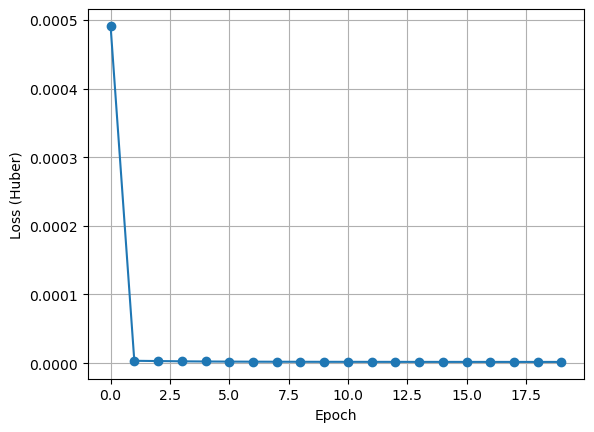

In [25]:
plt.plot(history.history["loss"], "o-", label = "Training Loss")
plt.xlabel("Epoch")
# plt.yscale('log')
plt.ylabel("Loss (Huber)")
plt.grid('on')

plt.savefig("loss_all.png", dpi=300)


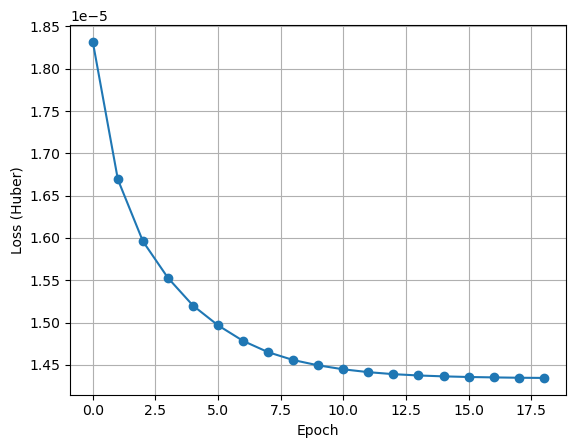

In [14]:
plt.plot(history.history["loss"][1:], "o-", label = "Training Loss")
plt.xlabel("Epoch")
# plt.yscale('log')
plt.ylabel("Loss (Huber)")
plt.grid('on')
plt.savefig("loss_1_to_end.png", dpi=300)


## Test the model

In [184]:
# test on all test data
model_large.evaluate(X_test[species_columns], y_test[species_columns])

7821/7821 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 7.4076e-07


1.0149801710213069e-06

In [185]:
# test on non-reactive data
model_large.evaluate(X_test[X_test['Class'] == 0].iloc[:,species_columns], y_test[X_test['Class'] == 0].iloc[:,species_columns])

IndexError: .iloc requires numeric indexers, got ['H' 'O' 'Charge' 'Ba' 'Cl' 'S_6_' 'Sr' 'Barite' 'Celestite']

In [17]:
mass_balance = mass_balance(model_simple, X_test, scaler_X, func_dict_in, func_dict_out)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0710e-05


In [116]:
# test on reactive data
model_large.evaluate(X_test[X_test['Class'] == 1].iloc[:,:-1], y_test[X_test['Class'] == 1].iloc[:, :-1])

4.047931361128576e-05

## Save the model

In [53]:
# Save the model
model.save("Barite_50_Model_additional_species.keras")

## Legacy Code

def log_scale(df_design, df_result, func_dict):
    
    df_design = df_design.copy()
    df_result = df_result.copy()
    
    for key in df_design.keys():
        if key != "Class":
            df_design[key] = np.vectorize(func_dict[key])(df_design[key])
            df_result[key] = np.vectorize(func_dict[key])(df_result[key])
        
    return df_design, df_result

# Get minimum and maximum values for each column
def get_min_max(df_design, df_result):
    
    min_vals_des = df_design.min()
    max_vals_des = df_design.max()
    
    min_vals_res = df_result.min()
    max_vals_res = df_result.max()

    # minimum of input and output data to get global minimum/maximum
    data_min = np.minimum(min_vals_des, min_vals_res).to_dict()
    data_max = np.maximum(max_vals_des, max_vals_res).to_dict()

    return data_min, data_max

df_design_log, df_results_log = log_scale(df_design, df_results, func_dict_in)
data_min_log, data_max_log = get_min_max(df_design_log, df_design_log)

train_min_log, train_max_log = get_min_max(X_train_log, y_train_log)
test_min_log, test_max_log = get_min_max(X_test_log, y_test_log)

X_train_preprocess = preprocess(X_train_log, func_dict_in, train_min_log, train_max_log)
y_train_preprocess = preprocess(y_train_log, func_dict_in, train_min_log, train_max_log)

X_test_preprocess = preprocess(X_test_log, func_dict_in, test_min_log, test_max_log)
y_test_preprocess = preprocess(y_test_log, func_dict_in, test_min_log, test_max_log)

X_train_log, y_train_log = log_scale(X_train, y_train, func_dict_in)
X_test_log, y_test_log = log_scale(X_test, y_test, func_dict_in)


def preprocess(data, func_dict, data_min, data_max):
    data = data.copy()
    for key in data.keys():
        if key != "Class":
            data[key] = (data[key] - data_min[key]) / (data_max[key] - data_min[key])

    return data

def postprocess(data, func_dict, data_min, data_max):
    data = data.copy()
    for key in data.keys():
        if key != "Class":
            data[key] = data[key] * (data_max[key] - data_min[key]) + data_min[key]
            data[key] = np.vectorize(func_dict[key])(data[key])
    return data

X_train, X_val, y_train, y_val = sk.train_test_split(X_train_preprocess, y_train_preprocess, test_size = 0.1)

pp_design = preprocess(df_design_log, func_dict_in, data_min_log, data_max_log)
pp_results = preprocess(df_results_log, func_dict_in, data_min_log, data_max_log)